# Parameterisation

In this notebook, we show how to find which parameters are needed in a model and define them.

For other notebooks about parameterization, see:

- The API documentation of [Parameters](https://docs.pybamm.org/en/latest/source/api/parameters/index.html)
- [Setting parameter values](https://github.com/pybamm-team/PyBaMM/blob/develop/docs/source/examples/notebooks/getting_started/tutorial-4-setting-parameter-values.ipynb) can be found at `pybamm/docs/source/examples/notebooks/getting_started/tutorial-4-setting-parameter-values.ipynb`. This explains the basics of how to set the parameters of a model (in less detail than here).
- [parameter-values.ipynb](https://github.com/pybamm-team/PyBaMM/blob/develop/docs/source/examples/notebooks/parameterization/parameter-values.ipynb) can be found at `pybamm/examples/notebooks/parameterization/parameter-values.ipynb`. This explains the basics of the `ParameterValues` class.


## Adding your own parameter sets (using a dictionary)

We will be using the model defined and explained in more detail in [3-negative-particle-problem.ipynb](https://github.com/pybamm-team/PyBaMM/blob/develop/docs/source/examples/notebooks/creating_models/3-negative-particle-problem.ipynb) example notebook. We begin by importing the required libraries

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import matplotlib.pyplot as plt

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Note: you may need to restart the kernel to use updated packages.


## Setting up the model

We define all the parameters and variables using `pybamm.Parameter` and `pybamm.Variable` respectively.

In [2]:
c = pybamm.Variable("Concentration [mol.m-3]", domain="negative particle")

R = pybamm.Parameter("Particle radius [m]")
D = pybamm.FunctionParameter("Diffusion coefficient [m2.s-1]", {"Concentration [mol.m-3]": c})
j = pybamm.InputParameter("Interfacial current density [A.m-2]")
c0 = pybamm.Parameter("Initial concentration [mol.m-3]")
c_e = pybamm.Parameter("Electrolyte concentration [mol.m-3]")

Now we define our model equations, boundary and initial conditions. We also add the variables required using the dictionary `model.variables`

In [3]:
model = pybamm.BaseModel()

# governing equations
N = -D * pybamm.grad(c)  # flux
dcdt = -pybamm.div(N)
model.rhs = {c: dcdt}  

# boundary conditions 
lbc = pybamm.Scalar(0)
rbc = -j
model.boundary_conditions = {c: {"left": (lbc, "Neumann"), "right": (rbc, "Neumann")}}

# initial conditions 
model.initial_conditions = {c: c0}

model.variables = {
    "Concentration [mol.m-3]": c,
    "Surface concentration [mol.m-3]": pybamm.surf(c),
    "Flux [mol.m-2.s-1]": N,
}

We also define the geometry, since there are parameters in the geometry too

In [4]:
r = pybamm.SpatialVariable("r", domain=["negative particle"], coord_sys="spherical polar")
geometry = pybamm.Geometry({"negative particle": {r: {"min": pybamm.Scalar(0), "max": R}}})

## Finding the parameters required

To know what parameters are required by the model and geometry, we can do

In [5]:
model.print_parameter_info()
geometry.print_parameter_info()

| Parameter                           | Type of parameter                                          |
| =================================== | ========================================================== |
| Initial concentration [mol.m-3]     | Parameter                                                  |
| Interfacial current density [A.m-2] | InputParameter                                             |
| Diffusion coefficient [m2.s-1]      | FunctionParameter with inputs(s) 'Concentration [mol.m-3]' |
Particle radius [m] (Parameter)


This tells us that we need to provide parameter values for the initial concentration and Faraday constant, an `InputParameter` at solve time for the interfacial current density, and diffusivity as a function of concentration. Since the electrolyte concentration does not appear anywhere in the model, there is no need to provide a value for it.

## Adding the parameters

Now we can proceed to the step where we add the `parameter` values using a dictionary. We set up a dictionary with parameter names as the dictionary keys and their respective values as the dictionary values.

In [6]:
def D_fun(c):
    return 3.9 #* pybamm.exp(-c)


values = {
    "Particle radius [m]": 2,
    "Diffusion coefficient [m2.s-1]": D_fun,
    "Initial concentration [mol.m-3]": 2.5,
}

Now we can pass this dictionary in `pybamm.ParameterValues` class which accepts a dictionary of parameter names and values. We can then print `param` to check if it was initialised.

In [7]:
param = pybamm.ParameterValues(values)

param

{'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Diffusion coefficient [m2.s-1]': <function D_fun at 0x7f48221f0220>,
 'Electron charge [C]': 1.602176634e-19,
 'Faraday constant [C.mol-1]': 96485.33212,
 'Ideal gas constant [J.K-1.mol-1]': 8.314462618,
 'Initial concentration [mol.m-3]': 2.5,
 'Particle radius [m]': 2}

## Updating the parameter values

The parameter values or `param` can be further updated by using the `update` function of `ParameterValues` class. The `update` function takes a dictionary with keys being the parameters to be updated and their respective values being the updated values. Here we update the `"Particle radius [m]"` parameter's value. Additionally, a function can also be passed as a `parameter`'s value which we will see ahead, and a new `parameter` can also be added by passing `check_already_exists=False` in the `update` function.

In [8]:
param.update({"Initial concentration [mol.m-3]": 1.5})
param

{'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Diffusion coefficient [m2.s-1]': <function D_fun at 0x7f48221f0220>,
 'Electron charge [C]': 1.602176634e-19,
 'Faraday constant [C.mol-1]': 96485.33212,
 'Ideal gas constant [J.K-1.mol-1]': 8.314462618,
 'Initial concentration [mol.m-3]': 1.5,
 'Particle radius [m]': 2}

## Solving the model 

## Finding the parameters in a model

The `parameter` function of the `BaseModel` class can be used to obtain the parameters of a model.

In [9]:
parameters = model.parameters
parameters

[Parameter(-0x60748912cbf94f86, Initial concentration [mol.m-3], children=[], domains={}),
 InputParameter(0x650425db234f99f4, Interfacial current density [A.m-2], children=[], domains={}),
 FunctionParameter(-0x302b1e5afcbfd4d9, Diffusion coefficient [m2.s-1], children=['Concentration [mol.m-3]'], domains={'primary': ['negative particle']})]

As explained in the [3-negative-particle-problem.ipynb](https://github.com/pybamm-team/PyBaMM/blob/develop/docs/source/examples/notebooks/creating_models/3-negative-particle-problem.ipynb) example, we first process both the `model` and the `geometry`.

In [10]:
param.process_model(model)
param.process_geometry(geometry)

We can now set up our mesh, choose a spatial method, and discretise our model

In [11]:
submesh_types = {"negative particle": pybamm.Uniform1DSubMesh}
var_pts = {r: 20}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

spatial_methods = {"negative particle": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model);

We choose a solver and times at which we want the solution returned, and solve the model. Here we give a value for the current density `j`.

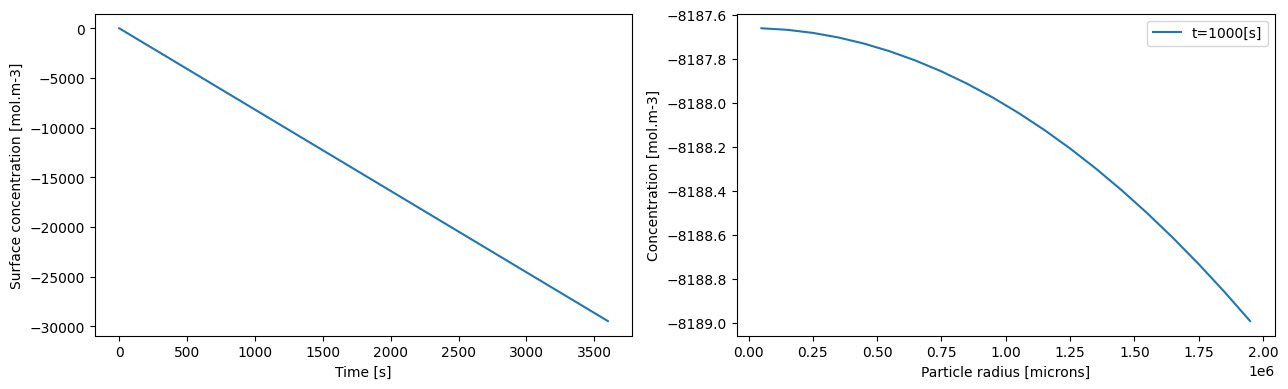

In [12]:
# solve
solver = pybamm.ScipySolver()
t = np.linspace(0, 3600, 600)
solution = solver.solve(model, t, inputs={"Interfacial current density [A.m-2]": 1.4})

# post-process, so that the solution can be called at any time t or space r
# (using interpolation)
c = solution["Concentration [mol.m-3]"]
c_surf = solution["Surface concentration [mol.m-3]"]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, c_surf(solution.t))
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Surface concentration [mol.m-3]")

rsol = mesh["negative particle"].nodes # radial position
time = 1000  # time in seconds
ax2.plot(rsol * 1e6, c(t=time, r=rsol), label=f"t={time}[s]")
ax2.set_xlabel("Particle radius [microns]")
ax2.set_ylabel("Concentration [mol.m-3]")
ax2.legend()

plt.tight_layout()
plt.show()

## Using pre-defined models in `PyBaMM`

In the next few steps, we will be showing the same workflow with the Single Particle Model (`SPM`). We will also see how you can pass a function as a `parameter`'s value and how to plot such `parameter functions`.

We start by initializing our model

In [13]:
spm = pybamm.lithium_ion.SPM()

## Finding the parameters in a model

We can print the `parameters` of a model by using the `print_parameter_info` function.

In [14]:
spm.print_parameter_info()

| Parameter                                                 | Type of parameter                                                                                                                                                                                           |
| ========================================================= | =========================================================================================================================================================================================================== |
| Positive electrode Bruggeman coefficient (electrolyte)    | Parameter                                                                                                                                                                                                   |
| Electrode width [m]                                       | Parameter                                                                                                                             

Note that there are no `InputParameter` objects in the default SPM. Also, note that if a `FunctionParameter` is expected, it is ok to provide a scalar (parameter) instead. However, if a `Parameter` is expected, you cannot provide a function instead.

Another way to view what parameters are needed is to print the default parameter values. This can also be used to get some good defaults (but care must be taken when combining parameters across datasets and chemistries)

In [15]:
{k: v for k,v in spm.default_parameter_values.items() if k in spm.get_parameter_info()}

{'Ideal gas constant [J.K-1.mol-1]': 8.314462618,
 'Faraday constant [C.mol-1]': 96485.33212,
 'Negative electrode thickness [m]': 0.0001,
 'Separator thickness [m]': 2.5e-05,
 'Positive electrode thickness [m]': 0.0001,
 'Electrode height [m]': 0.137,
 'Electrode width [m]': 0.207,
 'Nominal cell capacity [A.h]': 0.680616,
 'Current function [A]': 0.680616,
 'Maximum concentration in negative electrode [mol.m-3]': 24983.2619938437,
 'Negative electrode diffusivity [m2.s-1]': <function pybamm.input.parameters.lithium_ion.Marquis2019.graphite_mcmb2528_diffusivity_Dualfoil1998(sto, T)>,
 'Negative electrode OCP [V]': <function pybamm.input.parameters.lithium_ion.Marquis2019.graphite_mcmb2528_ocp_Dualfoil1998(sto)>,
 'Negative electrode porosity': 0.3,
 'Negative electrode active material volume fraction': 0.6,
 'Negative particle radius [m]': 1e-05,
 'Negative electrode Bruggeman coefficient (electrolyte)': 1.5,
 'Negative electrode Bruggeman coefficient (electrode)': 1.5,
 'Negative ele

We now define a dictionary of values for `ParameterValues` as before (here, a subset of the `Chen2020` parameters)

In [16]:
def graphite_mcmb2528_diffusivity_Dualfoil1998(sto, T):
    D_ref = 3.9 * 10 ** (-14)
    E_D_s = 42770
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
    return D_ref * arrhenius


neg_ocp = np.array([[0.        , 1.81772748],
         [0.03129623, 1.0828807 ],
         [0.03499902, 0.99593794],
         [0.0387018 , 0.90023398],
         [0.04240458, 0.79649431],
         [0.04610736, 0.73354429],
         [0.04981015, 0.66664314],
         [0.05351292, 0.64137149],
         [0.05721568, 0.59813869],
         [0.06091845, 0.5670836 ],
         [0.06462122, 0.54746181],
         [0.06832399, 0.53068399],
         [0.07202675, 0.51304734],
         [0.07572951, 0.49394092],
         [0.07943227, 0.47926274],
         [0.08313503, 0.46065259],
         [0.08683779, 0.45992726],
         [0.09054054, 0.43801501],
         [0.09424331, 0.42438665],
         [0.09794607, 0.41150269],
         [0.10164883, 0.40033659],
         [0.10535158, 0.38957134],
         [0.10905434, 0.37756538],
         [0.1127571 , 0.36292541],
         [0.11645985, 0.34357086],
         [0.12016261, 0.3406314 ],
         [0.12386536, 0.32299468],
         [0.12756811, 0.31379458],
         [0.13127086, 0.30795386],
         [0.13497362, 0.29207319],
         [0.13867638, 0.28697687],
         [0.14237913, 0.27405477],
         [0.14608189, 0.2670497 ],
         [0.14978465, 0.25857493],
         [0.15348741, 0.25265783],
         [0.15719018, 0.24826777],
         [0.16089294, 0.2414345 ],
         [0.1645957 , 0.23362778],
         [0.16829847, 0.22956218],
         [0.17200122, 0.22370236],
         [0.17570399, 0.22181271],
         [0.17940674, 0.22089651],
         [0.1831095 , 0.2194268 ],
         [0.18681229, 0.21830064],
         [0.19051504, 0.21845333],
         [0.1942178 , 0.21753715],
         [0.19792056, 0.21719357],
         [0.20162334, 0.21635373],
         [0.2053261 , 0.21667822],
         [0.20902886, 0.21738444],
         [0.21273164, 0.21469313],
         [0.2164344 , 0.21541846],
         [0.22013716, 0.21465495],
         [0.22383993, 0.2135479 ],
         [0.2275427 , 0.21392964],
         [0.23124547, 0.21074206],
         [0.23494825, 0.20873788],
         [0.23865101, 0.20465319],
         [0.24235377, 0.20205732],
         [0.24605653, 0.19774358],
         [0.2497593 , 0.19444147],
         [0.25346208, 0.19190285],
         [0.25716486, 0.18850531],
         [0.26086762, 0.18581399],
         [0.26457039, 0.18327537],
         [0.26827314, 0.18157659],
         [0.2719759 , 0.17814088],
         [0.27567867, 0.17529686],
         [0.27938144, 0.1719375 ],
         [0.28308421, 0.16934161],
         [0.28678698, 0.16756649],
         [0.29048974, 0.16609676],
         [0.29419251, 0.16414985],
         [0.29789529, 0.16260378],
         [0.30159806, 0.16224113],
         [0.30530083, 0.160027  ],
         [0.30900361, 0.15827096],
         [0.31270637, 0.1588054 ],
         [0.31640913, 0.15552238],
         [0.32011189, 0.15580869],
         [0.32381466, 0.15220118],
         [0.32751744, 0.1511132 ],
         [0.33122021, 0.14987253],
         [0.33492297, 0.14874637],
         [0.33862575, 0.14678037],
         [0.34232853, 0.14620776],
         [0.34603131, 0.14555879],
         [0.34973408, 0.14389819],
         [0.35343685, 0.14359279],
         [0.35713963, 0.14242846],
         [0.36084241, 0.14038612],
         [0.36454517, 0.13882096],
         [0.36824795, 0.13954628],
         [0.37195071, 0.13946992],
         [0.37565348, 0.13780934],
         [0.37935626, 0.13973714],
         [0.38305904, 0.13698858],
         [0.38676182, 0.13523254],
         [0.3904646 , 0.13441178],
         [0.39416737, 0.1352898 ],
         [0.39787015, 0.13507985],
         [0.40157291, 0.13647321],
         [0.40527567, 0.13601512],
         [0.40897844, 0.13435452],
         [0.41268121, 0.1334765 ],
         [0.41638398, 0.1348317 ],
         [0.42008676, 0.13275118],
         [0.42378953, 0.13286571],
         [0.4274923 , 0.13263667],
         [0.43119506, 0.13456447],
         [0.43489784, 0.13471718],
         [0.43860061, 0.13395369],
         [0.44230338, 0.13448814],
         [0.44600615, 0.1334765 ],
         [0.44970893, 0.13298023],
         [0.45341168, 0.13259849],
         [0.45711444, 0.13338107],
         [0.46081719, 0.13309476],
         [0.46451994, 0.13275118],
         [0.46822269, 0.13443087],
         [0.47192545, 0.13315202],
         [0.47562821, 0.132713  ],
         [0.47933098, 0.1330184 ],
         [0.48303375, 0.13278936],
         [0.48673651, 0.13225491],
         [0.49043926, 0.13317111],
         [0.49414203, 0.13263667],
         [0.49784482, 0.13187316],
         [0.50154759, 0.13265574],
         [0.50525036, 0.13250305],
         [0.50895311, 0.13324745],
         [0.51265586, 0.13204496],
         [0.51635861, 0.13242669],
         [0.52006139, 0.13233127],
         [0.52376415, 0.13198769],
         [0.52746692, 0.13254122],
         [0.53116969, 0.13145325],
         [0.53487245, 0.13298023],
         [0.53857521, 0.13168229],
         [0.54227797, 0.1313578 ],
         [0.54598074, 0.13235036],
         [0.5496835 , 0.13120511],
         [0.55338627, 0.13089971],
         [0.55708902, 0.13109058],
         [0.56079178, 0.13082336],
         [0.56449454, 0.13011713],
         [0.5681973 , 0.129869  ],
         [0.57190006, 0.12992626],
         [0.57560282, 0.12942998],
         [0.57930558, 0.12796026],
         [0.58300835, 0.12862831],
         [0.58671112, 0.12656689],
         [0.59041389, 0.12734947],
         [0.59411664, 0.12509716],
         [0.59781941, 0.12110791],
         [0.60152218, 0.11839751],
         [0.60522496, 0.11244226],
         [0.60892772, 0.11307214],
         [0.61263048, 0.1092165 ],
         [0.61633325, 0.10683058],
         [0.62003603, 0.10433014],
         [0.6237388 , 0.10530359],
         [0.62744156, 0.10056993],
         [0.63114433, 0.09950104],
         [0.63484711, 0.09854668],
         [0.63854988, 0.09921473],
         [0.64225265, 0.09541635],
         [0.64595543, 0.09980643],
         [0.64965823, 0.0986612 ],
         [0.653361  , 0.09560722],
         [0.65706377, 0.09755413],
         [0.66076656, 0.09612258],
         [0.66446934, 0.09430929],
         [0.66817212, 0.09661885],
         [0.67187489, 0.09366032],
         [0.67557767, 0.09522548],
         [0.67928044, 0.09535909],
         [0.68298322, 0.09316404],
         [0.686686  , 0.09450016],
         [0.69038878, 0.0930877 ],
         [0.69409156, 0.09343126],
         [0.69779433, 0.0932404 ],
         [0.70149709, 0.09350762],
         [0.70519988, 0.09339309],
         [0.70890264, 0.09291591],
         [0.7126054 , 0.09303043],
         [0.71630818, 0.0926296 ],
         [0.72001095, 0.0932404 ],
         [0.72371371, 0.09261052],
         [0.72741648, 0.09249599],
         [0.73111925, 0.09240055],
         [0.73482204, 0.09253416],
         [0.7385248 , 0.09209515],
         [0.74222757, 0.09234329],
         [0.74593034, 0.09366032],
         [0.74963312, 0.09333583],
         [0.75333589, 0.09322131],
         [0.75703868, 0.09264868],
         [0.76074146, 0.09253416],
         [0.76444422, 0.09243873],
         [0.76814698, 0.09230512],
         [0.77184976, 0.09310678],
         [0.77555253, 0.09165615],
         [0.77925531, 0.09159888],
         [0.78295807, 0.09207606],
         [0.78666085, 0.09175158],
         [0.79036364, 0.09177067],
         [0.79406641, 0.09236237],
         [0.79776918, 0.09241964],
         [0.80147197, 0.09320222],
         [0.80517474, 0.09199972],
         [0.80887751, 0.09167523],
         [0.81258028, 0.09322131],
         [0.81628304, 0.09190428],
         [0.81998581, 0.09167523],
         [0.82368858, 0.09285865],
         [0.82739136, 0.09180884],
         [0.83109411, 0.09150345],
         [0.83479688, 0.09186611],
         [0.83849965, 0.0920188 ],
         [0.84220242, 0.09320222],
         [0.84590519, 0.09131257],
         [0.84960797, 0.09117896],
         [0.85331075, 0.09133166],
         [0.85701353, 0.09089265],
         [0.86071631, 0.09058725],
         [0.86441907, 0.09051091],
         [0.86812186, 0.09033912],
         [0.87182464, 0.09041547],
         [0.87552742, 0.0911217 ],
         [0.87923019, 0.0894611 ],
         [0.88293296, 0.08999555],
         [0.88663573, 0.08921297],
         [0.89033849, 0.08881213],
         [0.89404126, 0.08797229],
         [0.89774404, 0.08709427],
         [0.9014468 , 0.08503284],
         [1.        , 0.07601531]])

pos_ocp = np.array([[0.24879728, 4.4       ],
         [0.26614516, 4.2935653 ],
         [0.26886763, 4.2768621 ],
         [0.27159011, 4.2647018 ],
         [0.27431258, 4.2540312 ],
         [0.27703505, 4.2449446 ],
         [0.27975753, 4.2364879 ],
         [0.28248   , 4.2302647 ],
         [0.28520247, 4.2225528 ],
         [0.28792495, 4.2182574 ],
         [0.29064743, 4.213294  ],
         [0.29336992, 4.2090373 ],
         [0.29609239, 4.2051239 ],
         [0.29881487, 4.2012677 ],
         [0.30153735, 4.1981564 ],
         [0.30425983, 4.1955218 ],
         [0.30698231, 4.1931167 ],
         [0.30970478, 4.1889744 ],
         [0.31242725, 4.1881533 ],
         [0.31514973, 4.1865883 ],
         [0.3178722 , 4.1850228 ],
         [0.32059466, 4.1832285 ],
         [0.32331714, 4.1808805 ],
         [0.32603962, 4.1805749 ],
         [0.32876209, 4.1789522 ],
         [0.33148456, 4.1768146 ],
         [0.33420703, 4.1768146 ],
         [0.3369295 , 4.1752872 ],
         [0.33965197, 4.173111  ],
         [0.34237446, 4.1726718 ],
         [0.34509694, 4.1710877 ],
         [0.34781941, 4.1702285 ],
         [0.3505419 , 4.168797  ],
         [0.35326438, 4.1669831 ],
         [0.35598685, 4.1655135 ],
         [0.35870932, 4.1634517 ],
         [0.3614318 , 4.1598248 ],
         [0.36415428, 4.1571712 ],
         [0.36687674, 4.154079  ],
         [0.36959921, 4.1504135 ],
         [0.37232169, 4.1466532 ],
         [0.37504418, 4.1423388 ],
         [0.37776665, 4.1382346 ],
         [0.38048913, 4.1338248 ],
         [0.38321161, 4.1305799 ],
         [0.38593408, 4.1272392 ],
         [0.38865655, 4.1228104 ],
         [0.39137903, 4.1186109 ],
         [0.39410151, 4.114182  ],
         [0.39682398, 4.1096005 ],
         [0.39954645, 4.1046948 ],
         [0.40226892, 4.1004758 ],
         [0.4049914 , 4.0956464 ],
         [0.40771387, 4.0909696 ],
         [0.41043634, 4.0864644 ],
         [0.41315882, 4.0818448 ],
         [0.41588129, 4.077683  ],
         [0.41860377, 4.0733309 ],
         [0.42132624, 4.0690737 ],
         [0.42404872, 4.0647216 ],
         [0.4267712 , 4.0608654 ],
         [0.42949368, 4.0564747 ],
         [0.43221616, 4.0527525 ],
         [0.43493864, 4.0492401 ],
         [0.43766111, 4.0450211 ],
         [0.44038359, 4.041986  ],
         [0.44310607, 4.0384736 ],
         [0.44582856, 4.035171  ],
         [0.44855103, 4.0320406 ],
         [0.45127351, 4.0289288 ],
         [0.453996  , 4.02597   ],
         [0.45671848, 4.0227437 ],
         [0.45944095, 4.0199757 ],
         [0.46216343, 4.0175133 ],
         [0.46488592, 4.0149746 ],
         [0.46760838, 4.0122066 ],
         [0.47033085, 4.009954  ],
         [0.47305333, 4.0075679 ],
         [0.47577581, 4.0050669 ],
         [0.47849828, 4.0023184 ],
         [0.48122074, 3.9995501 ],
         [0.48394321, 3.9969349 ],
         [0.48666569, 3.9926589 ],
         [0.48938816, 3.9889555 ],
         [0.49211064, 3.9834003 ],
         [0.4948331 , 3.9783037 ],
         [0.49755557, 3.9755929 ],
         [0.50027804, 3.9707632 ],
         [0.50300052, 3.9681098 ],
         [0.50572298, 3.9635665 ],
         [0.50844545, 3.9594433 ],
         [0.51116792, 3.9556634 ],
         [0.51389038, 3.9521511 ],
         [0.51661284, 3.9479132 ],
         [0.51933531, 3.9438281 ],
         [0.52205777, 3.9400866 ],
         [0.52478024, 3.9362304 ],
         [0.52750271, 3.9314201 ],
         [0.53022518, 3.9283848 ],
         [0.53294765, 3.9242232 ],
         [0.53567012, 3.9192028 ],
         [0.53839258, 3.9166257 ],
         [0.54111506, 3.9117961 ],
         [0.54383753, 3.90815   ],
         [0.54656   , 3.9038739 ],
         [0.54928247, 3.8995597 ],
         [0.55200494, 3.8959136 ],
         [0.5547274 , 3.8909314 ],
         [0.55744986, 3.8872662 ],
         [0.56017233, 3.8831048 ],
         [0.5628948 , 3.8793442 ],
         [0.56561729, 3.8747628 ],
         [0.56833976, 3.8702576 ],
         [0.57106222, 3.8666878 ],
         [0.57378469, 3.8623927 ],
         [0.57650716, 3.8581741 ],
         [0.57922963, 3.854146  ],
         [0.5819521 , 3.8499846 ],
         [0.58467456, 3.8450022 ],
         [0.58739702, 3.8422534 ],
         [0.59011948, 3.8380919 ],
         [0.59284194, 3.8341596 ],
         [0.5955644 , 3.8309333 ],
         [0.59828687, 3.8272109 ],
         [0.60100935, 3.823164  ],
         [0.60373182, 3.8192315 ],
         [0.60645429, 3.8159864 ],
         [0.60917677, 3.8123021 ],
         [0.61189925, 3.8090379 ],
         [0.61462172, 3.8071671 ],
         [0.61734419, 3.8040555 ],
         [0.62006666, 3.8013639 ],
         [0.62278914, 3.7970879 ],
         [0.62551162, 3.7953317 ],
         [0.62823408, 3.7920673 ],
         [0.63095656, 3.788383  ],
         [0.63367903, 3.7855389 ],
         [0.6364015 , 3.7838206 ],
         [0.63912397, 3.78111   ],
         [0.64184645, 3.7794874 ],
         [0.64456893, 3.7769294 ],
         [0.6472914 , 3.773608  ],
         [0.65001389, 3.7695992 ],
         [0.65273637, 3.7690265 ],
         [0.65545884, 3.7662776 ],
         [0.65818131, 3.7642922 ],
         [0.66090379, 3.7626889 ],
         [0.66362625, 3.7603791 ],
         [0.66634874, 3.7575538 ],
         [0.66907121, 3.7552056 ],
         [0.67179369, 3.7533159 ],
         [0.67451616, 3.7507198 ],
         [0.67723865, 3.7487535 ],
         [0.67996113, 3.7471499 ],
         [0.68268361, 3.7442865 ],
         [0.68540608, 3.7423012 ],
         [0.68812855, 3.7400677 ],
         [0.69085103, 3.7385788 ],
         [0.6935735 , 3.7345319 ],
         [0.69629597, 3.7339211 ],
         [0.69901843, 3.7301605 ],
         [0.7017409 , 3.7301033 ],
         [0.70446338, 3.7278316 ],
         [0.70718585, 3.7251589 ],
         [0.70990833, 3.723861  ],
         [0.71263081, 3.7215703 ],
         [0.71535328, 3.7191267 ],
         [0.71807574, 3.7172751 ],
         [0.72079822, 3.7157097 ],
         [0.72352069, 3.7130945 ],
         [0.72624317, 3.7099447 ],
         [0.72896564, 3.7071004 ],
         [0.7316881 , 3.7045615 ],
         [0.73441057, 3.703588  ],
         [0.73713303, 3.70208   ],
         [0.73985551, 3.7002664 ],
         [0.74257799, 3.6972122 ],
         [0.74530047, 3.6952841 ],
         [0.74802293, 3.6929362 ],
         [0.7507454 , 3.6898055 ],
         [0.75346787, 3.6890991 ],
         [0.75619034, 3.686522  ],
         [0.75891281, 3.6849759 ],
         [0.76163529, 3.6821697 ],
         [0.76435776, 3.6808143 ],
         [0.76708024, 3.6786573 ],
         [0.7698027 , 3.6761947 ],
         [0.77252517, 3.674763  ],
         [0.77524765, 3.6712887 ],
         [0.77797012, 3.6697233 ],
         [0.78069258, 3.6678908 ],
         [0.78341506, 3.6652565 ],
         [0.78613753, 3.6630611 ],
         [0.78885999, 3.660274  ],
         [0.79158246, 3.6583652 ],
         [0.79430494, 3.6554828 ],
         [0.79702741, 3.6522949 ],
         [0.79974987, 3.6499848 ],
         [0.80247234, 3.6470451 ],
         [0.8051948 , 3.6405547 ],
         [0.80791727, 3.6383405 ],
         [0.81063974, 3.635076  ],
         [0.81336221, 3.633549  ],
         [0.81608468, 3.6322317 ],
         [0.81880714, 3.6306856 ],
         [0.82152961, 3.6283948 ],
         [0.82425208, 3.6268487 ],
         [0.82697453, 3.6243098 ],
         [0.829697  , 3.6223626 ],
         [0.83241946, 3.6193655 ],
         [0.83514192, 3.6177621 ],
         [0.83786439, 3.6158531 ],
         [0.84058684, 3.6128371 ],
         [0.84330931, 3.6118062 ],
         [0.84603177, 3.6094582 ],
         [0.84875424, 3.6072438 ],
         [0.8514767 , 3.6049912 ],
         [0.85419916, 3.6030822 ],
         [0.85692162, 3.6012688 ],
         [0.85964409, 3.5995889 ],
         [0.86236656, 3.5976417 ],
         [0.86508902, 3.5951984 ],
         [0.86781149, 3.593843  ],
         [0.87053395, 3.5916286 ],
         [0.87325642, 3.5894907 ],
         [0.87597888, 3.587429  ],
         [0.87870135, 3.5852909 ],
         [0.88142383, 3.5834775 ],
         [0.8841463 , 3.5817785 ],
         [0.88686877, 3.5801177 ],
         [0.88959124, 3.5778842 ],
         [0.89231371, 3.5763381 ],
         [0.8950362 , 3.5737801 ],
         [0.89775868, 3.5721002 ],
         [0.90048116, 3.5702102 ],
         [0.90320364, 3.5684922 ],
         [0.90592613, 3.5672133 ],
         [1.        , 3.52302167]])

from pybamm import exp, constants


def graphite_LGM50_electrolyte_exchange_current_density_Chen2020(c_e, c_s_surf, c_n_max, T):
    m_ref = 6.48e-7  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 35000
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * arrhenius * c_e ** 0.5 * c_s_surf ** 0.5 * (c_n_max - c_s_surf) ** 0.5
    )


def nmc_LGM50_electrolyte_exchange_current_density_Chen2020(c_e, c_s_surf, c_p_max, T):
    m_ref = 3.42e-6  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 17800
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * arrhenius * c_e ** 0.5 * c_s_surf ** 0.5 * (c_p_max - c_s_surf) ** 0.5
    )


values = {
 'Negative electrode thickness [m]': 8.52e-05,
 'Separator thickness [m]': 1.2e-05,
 'Positive electrode thickness [m]': 7.56e-05,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Nominal cell capacity [A.h]': 5.0,
 'Typical current [A]': 5.0,
 'Current function [A]': 5.0,
 'Maximum concentration in negative electrode [mol.m-3]': 33133.0,
 'Negative electrode diffusivity [m2.s-1]': 3.3e-14,
 'Negative electrode OCP [V]': ('graphite_LGM50_ocp_Chen2020', neg_ocp),
 'Negative electrode porosity': 0.25,
 'Negative electrode active material volume fraction': 0.75,
 'Negative particle radius [m]': 5.86e-06,
 'Negative electrode Bruggeman coefficient (electrolyte)': 1.5,
 'Negative electrode Bruggeman coefficient (electrode)': 1.5,
 'Negative electrode electrons in reaction': 1.0,
 'Negative electrode exchange-current density [A.m-2]': graphite_LGM50_electrolyte_exchange_current_density_Chen2020,
 'Negative electrode OCP entropic change [V.K-1]': 0.0,
 'Maximum concentration in positive electrode [mol.m-3]': 63104.0,
 'Positive electrode diffusivity [m2.s-1]': 4e-15,
 'Positive electrode OCP [V]': ('nmc_LGM50_ocp_Chen2020', pos_ocp),
 'Positive electrode porosity': 0.335,
 'Positive electrode active material volume fraction': 0.665,
 'Positive particle radius [m]': 5.22e-06,
 'Positive electrode Bruggeman coefficient (electrolyte)': 1.5,
 'Positive electrode Bruggeman coefficient (electrode)': 1.5,
 'Positive electrode electrons in reaction': 1.0,
 'Positive electrode exchange-current density [A.m-2]': nmc_LGM50_electrolyte_exchange_current_density_Chen2020,
 'Positive electrode OCP entropic change [V.K-1]': 0.0,
 'Separator porosity': 0.47,
 'Separator Bruggeman coefficient (electrolyte)': 1.5,
 'Typical electrolyte concentration [mol.m-3]': 1000.0,
 'Reference temperature [K]': 298.15,
 'Ambient temperature [K]': 298.15,
 'Number of electrodes connected in parallel to make a cell': 1.0,
 'Number of cells connected in series to make a battery': 1.0,
 'Lower voltage cut-off [V]': 2.5,
 'Upper voltage cut-off [V]': 4.4,
 "Initial concentration in electrolyte [mol.m-3]": 1000,
 'Initial concentration in negative electrode [mol.m-3]': 29866.0,
 'Initial concentration in positive electrode [mol.m-3]': 17038.0,
 'Initial temperature [K]': 298.15
}
param = pybamm.ParameterValues(values)
param

{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Current function [A]': 5.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electron charge [C]': 1.602176634e-19,
 'Faraday constant [C.mol-1]': 96485.33212,
 'Ideal gas constant [J.K-1.mol-1]': 8.314462618,
 'Initial concentration in electrolyte [mol.m-3]': 1000,
 'Initial concentration in negative electrode [mol.m-3]': 29866.0,
 'Initial concentration in positive electrode [mol.m-3]': 17038.0,
 'Initial temperature [K]': 298.15,
 'Lower voltage cut-off [V]': 2.5,
 'Maximum concentration in negative electrode [mol.m-3]': 33133.0,
 'Maximum concentration in positive electrode [mol.m-3]': 63104.0,
 'Negative electrode Bruggeman coefficient (electrode)': 1.5,
 'Negative electrode Bruggeman coefficient (electrolyte)': 1.5,
 'Negative electrode OCP [V]': ('graphite_LGM50_ocp_Chen2020',
                                ([array([0.        , 0.03129623, 0.03499902, 0.0387018 , 0.04240458,
      

Here we would have got the same result by doing

In [17]:
param_same = pybamm.ParameterValues("Chen2020")
{k: v for k,v in param_same.items() if k in spm.get_parameter_info()}

{'Ideal gas constant [J.K-1.mol-1]': 8.314462618,
 'Faraday constant [C.mol-1]': 96485.33212,
 'Negative electrode thickness [m]': 8.52e-05,
 'Separator thickness [m]': 1.2e-05,
 'Positive electrode thickness [m]': 7.56e-05,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Nominal cell capacity [A.h]': 5.0,
 'Current function [A]': 5.0,
 'Maximum concentration in negative electrode [mol.m-3]': 33133.0,
 'Negative electrode diffusivity [m2.s-1]': 3.3e-14,
 'Negative electrode OCP [V]': <function pybamm.input.parameters.lithium_ion.Chen2020.graphite_LGM50_ocp_Chen2020(sto)>,
 'Negative electrode porosity': 0.25,
 'Negative electrode active material volume fraction': 0.75,
 'Negative particle radius [m]': 5.86e-06,
 'Negative electrode Bruggeman coefficient (electrolyte)': 1.5,
 'Negative electrode Bruggeman coefficient (electrode)': 0,
 'Negative electrode exchange-current density [A.m-2]': <function pybamm.input.parameters.lithium_ion.Chen2020.graphite_LGM50_electrolyte_e

## Updating a specific parameter

Once a parameter set has been defined (either via a dictionary or a pre-built set), single parameters can be updated

### Using a constant value:

In [18]:
param.search("Current function [A]")

param.update({"Current function [A]": 4.0})

param["Current function [A]"]

Current function [A]	5.0


4.0

### Using a function:

In [19]:
def curren_func(time):
    return 1 + pybamm.sin(2 * np.pi * time / 60)


param.update({"Current function [A]": curren_func})

param["Current function [A]"]

<function __main__.curren_func(time)>

## Plotting parameter functions

As seen above, functions can be passed as parameter values. These parameter values can then be plotted by using `pybamm.plot`

### Plotting "Current function \[A]"

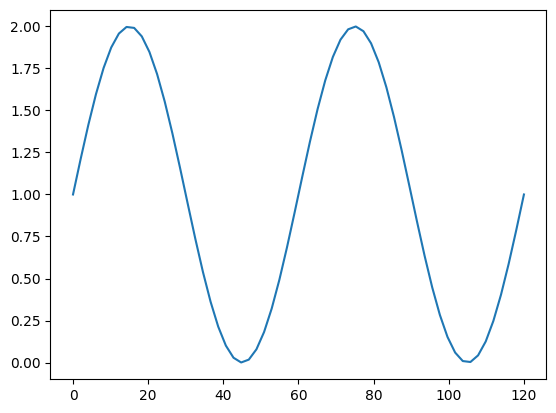

<Axes: >

In [20]:
currentfunc = param["Current function [A]"]
time = pybamm.linspace(0, 120, 60)
evaluated = param.evaluate(currentfunc(time))
evaluated = pybamm.Array(evaluated)
pybamm.plot(time, evaluated)

Taking another such example:

### Plotting "Negative electrode exchange-current density \[A.m-2]"

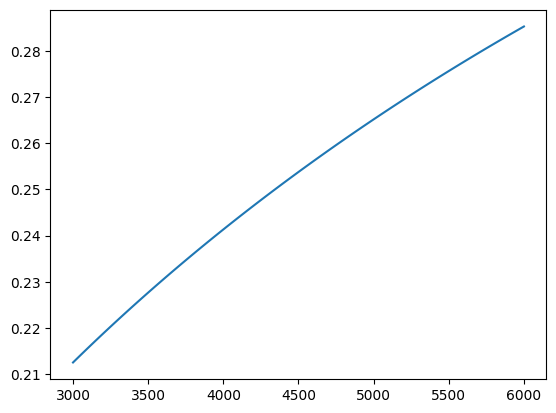

<Axes: >

In [21]:
negative_electrode_exchange_current_density = param["Negative electrode exchange-current density [A.m-2]"]
x = pybamm.linspace(3000,6000,100)
c_n_max = param["Maximum concentration in negative electrode [mol.m-3]"]
evaluated = param.evaluate(negative_electrode_exchange_current_density(1000,x,c_n_max,300))
evaluated = pybamm.Array(evaluated)
pybamm.plot(x, evaluated)

## Simulating and solving the model

Finally we can simulate the model and solve it using `pybamm.Simulation` and `solve` respectively.

In [22]:
sim = pybamm.Simulation(spm, parameter_values=param)
t_eval = np.arange(0, 3600, 1)
sim.solve(t_eval=t_eval)
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=3599.0, step=35.99), Output()), _dom_classes…

## References
The relevant papers for this notebook are:

In [23]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[3] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[4] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with elect